# **Traffic Sign Recognition with Gluon**

## **About DataSet**

### **Belgium Traffic Sign Dataset**
---
Dataset can be obtained from [HERE](http://btsd.ethz.ch/shareddata/).


There are huge datasets, but all we need are only two of those.
- BelgiumTSG_Training(171.3MBytes)
- BelgiumTSC_Testing(76.5Mbytes)



This tutorial uses these two paths:

    /traffic/datasets/BelgiumTS/Training/
    /traffic/datasets/BelgiumTS/Testing/

Each of the two directories contain 62 subdirectories, named sequentially from **00000** to **00061**. The directory names represent the labels, and the images inside each directory are samples of each label.

### **Exploring the Dataset**


In [2]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import mxnet as mx
from mxnet import gluon
from mxnet.gluon import nn, rnn
from tqdm import tqdm
from mxnet import  autograd
from sklearn.model_selection import StratifiedShuffleSplit

# Allow image embeding in notebook
%matplotlib inline

In [3]:
train_data_dir = '/Users/junui/traffic/datasets/BelgiumTS/Training/'
test_data_dir = '/Users/junui/traffic/datasets/BelgiumTS/Testing/'

#### **Load Images**

In [4]:
def load_data(data_dir):
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) 
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

images, labels = load_data(train_data_dir)

In [5]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 62
Total Images: 4575


#### **Display Images**

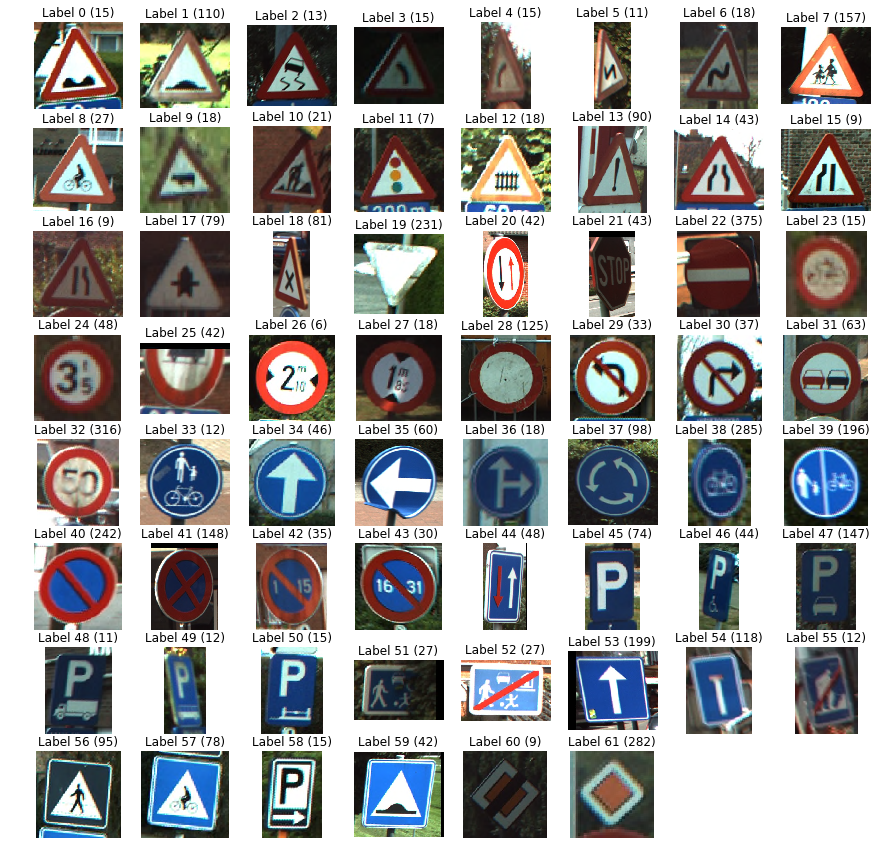

In [6]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

#### **Display Images with Label**

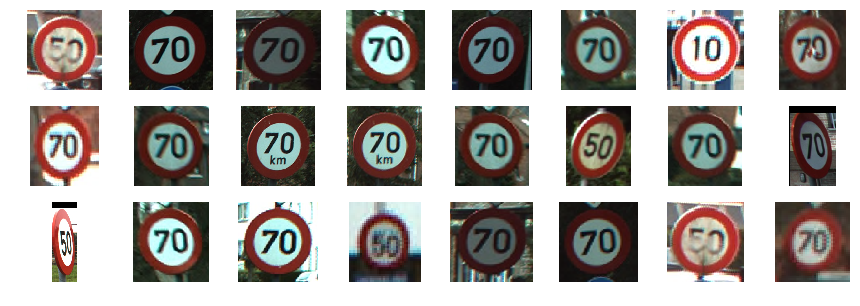

In [7]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 32)

#### **Handling Image's Size**

In [8]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (144, 141, 3), min: 3, max: 255
shape: (183, 187, 3), min: 0, max: 255
shape: (244, 253, 3), min: 0, max: 255
shape: (99, 97, 3), min: 4, max: 247
shape: (145, 146, 3), min: 0, max: 255


/Users/junui/anaconda/envs/tf/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


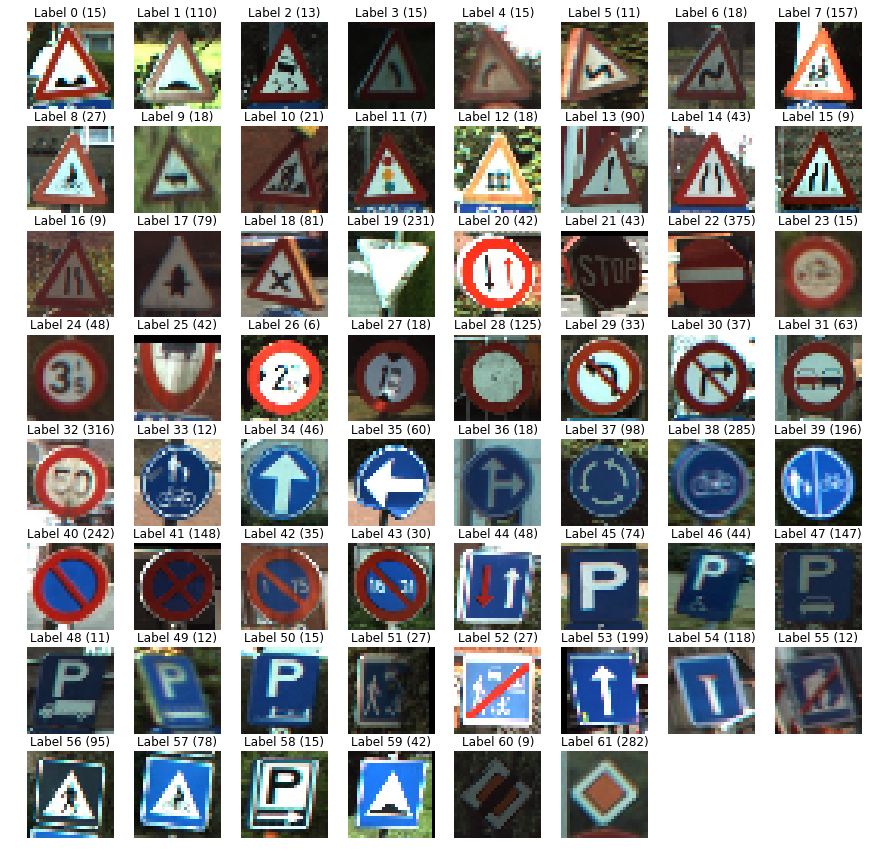

In [9]:
# Resize Images
images32 = [skimage.transform.resize(image, (28, 28))
                for image in images]
display_images_and_labels(images32, labels)

### **Preprocessing**

In [10]:
print(mx.nd.array(images32).shape)
print(mx.nd.transpose(mx.nd.array(images32).astype('float32'), (0, 3, 1, 2)).shape)

(4575, 28, 28, 3)
(4575, 3, 28, 28)


In [11]:
images32_t = mx.nd.transpose(mx.nd.array(images32).astype('float32'), (0, 3, 1, 2))
labels = mx.nd.array(labels)
print(images32_t.shape)
print(labels.shape)

(4575, 3, 28, 28)
(4575,)


In [12]:
print(gluon.data.ArrayDataset(images32_t, labels)[0][0])
print(gluon.data.ArrayDataset(images32_t, labels)[0][1])


[[[ 0.23368847  0.43642956  0.43032214 ...,  0.2769658   0.24364746
    0.27703083]
  [ 0.21775711  0.42478991  0.43858042 ...,  0.32027811  0.29614347
    0.28932574]
  [ 0.26872247  0.46604142  0.434984   ...,  0.38085735  0.37353441
    0.34388757]
  ..., 
  [ 0.41027412  0.43688476  0.43344837 ...,  0.19318227  0.1872649
    0.11066927]
  [ 0.44734395  0.38575929  0.37429971 ...,  0.1990246   0.15235095
    0.11062925]
  [ 0.44608343  0.38837534  0.38428873 ...,  0.17663565  0.14543317
    0.12885654]]

 [[ 0.42962185  0.54985994  0.53134751 ...,  0.30416167  0.27162865
    0.32436976]
  [ 0.40896359  0.54530811  0.5233143  ...,  0.33386853  0.32289416
    0.32435474]
  [ 0.46986294  0.58838034  0.51194477 ...,  0.34291717  0.32346439
    0.30856842]
  ..., 
  [ 0.53580934  0.55957383  0.53056222 ...,  0.18903561  0.18188275
    0.10427171]
  [ 0.55336636  0.50546217  0.48732492 ...,  0.19180672  0.13666466
    0.09404762]
  [ 0.55238098  0.48303822  0.48657462 ...,  0.18095239  0

In [13]:
dataset = gluon.data.ArrayDataset(images32_t, labels)

In [14]:
#data = np.array([])
data_list = []
label_list = []

In [15]:
for datum, label in dataset:
    data_list.append(datum.asnumpy())
    label_list.append(label)

In [16]:
data_nparray = np.array(data_list)
label_nparray = np.array(label_list)

In [17]:
print(data_nparray.shape)
print(label_nparray.shape)

(4575, 3, 28, 28)
(4575,)


In [18]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=910217)
sss.get_n_splits(data_nparray, label_nparray)

1

In [19]:
for train_index, test_index in sss.split(data_nparray, label_nparray):
    train_idx = train_index
    test_idx = test_index

print(train_idx.shape)
print(test_idx.shape)

(3202,)
(1373,)


In [20]:
train_data = data_nparray[train_idx]
test_data = data_nparray[test_idx]
train_label = label_nparray[train_idx]
test_label = label_nparray[test_idx]

In [21]:
def get_ratio(x):
    unique = list(set(x))
    label_ratio = dict()
    for label in unique:
        label_ratio[label] = round(sum(x == label) / len(x) * 100, 3)
    return label_ratio

In [22]:
get_ratio(train_label)

{0.0: 0.312,
 1.0: 2.4049999999999998,
 2.0: 0.28100000000000003,
 3.0: 0.312,
 4.0: 0.34399999999999997,
 5.0: 0.25,
 6.0: 0.40600000000000003,
 7.0: 3.4350000000000001,
 8.0: 0.59299999999999997,
 9.0: 0.40600000000000003,
 10.0: 0.46800000000000003,
 11.0: 0.156,
 12.0: 0.40600000000000003,
 13.0: 1.968,
 14.0: 0.93700000000000006,
 15.0: 0.187,
 16.0: 0.187,
 17.0: 1.718,
 18.0: 1.78,
 19.0: 5.0590000000000002,
 20.0: 0.90600000000000003,
 21.0: 0.93700000000000006,
 22.0: 8.1820000000000004,
 23.0: 0.34399999999999997,
 24.0: 1.0620000000000001,
 25.0: 0.90600000000000003,
 26.0: 0.125,
 27.0: 0.40600000000000003,
 28.0: 2.7170000000000001,
 29.0: 0.71799999999999997,
 30.0: 0.81200000000000006,
 31.0: 1.3740000000000001,
 32.0: 6.9020000000000001,
 33.0: 0.25,
 34.0: 0.999,
 35.0: 1.3120000000000001,
 36.0: 0.40600000000000003,
 37.0: 2.1549999999999998,
 38.0: 6.2149999999999999,
 39.0: 4.2789999999999999,
 40.0: 5.2779999999999996,
 41.0: 3.2480000000000002,
 42.0: 0.75,
 43.0:

In [23]:
train_set = gluon.data.ArrayDataset(train_data, train_label)
test_set = gluon.data.ArrayDataset(test_data, test_label)

In [24]:
test_set_iter  = gluon.data.DataLoader(test_set,  batch_size=120, shuffle=True)
train_set_iter = gluon.data.DataLoader(train_set, batch_size=120, shuffle=True)

In [25]:
for i, (data_x, data_y) in enumerate(train_set_iter):
    data_set_x = data_x
    data_set_y = data_y
    break

In [26]:
class f_mnist(gluon.Block):
    def __init__(self, **kwargs):
        super(f_mnist, self).__init__(**kwargs)
        with self.name_scope():
            self.conv0 = nn.Conv2D(channels=64, kernel_size=5, activation='relu')
            self.maxpool = nn.MaxPool2D()
            self.conv1 = nn.Conv2D(channels=128, kernel_size=3, activation='relu')
            self.avgpool = nn.GlobalAvgPool2D()
            self.dense = nn.Dense(10)
            
    def forward(self, inputs):
        x = self.conv0(inputs)
        x = self.maxpool(x)
        x = self.conv1(x)
        x = self.avgpool(x)
        return self.dense(x)

In [27]:
ctx = mx.cpu(0)

In [28]:
net = f_mnist()

In [29]:
def evaluate(net, data_iter, ctx):
    acc = mx.metric.Accuracy()
    for data_x, data_y in data_iter:
        data_x = data_x.as_in_context(ctx)
        data_y = data_y.as_in_context(ctx)
        with autograd.predict_mode():
            output = net(data_x)
        predictions = mx.nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=data_y)
        mx.ndarray.waitall()
    return acc.get()[1]

In [30]:
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
trainer = gluon.trainer.Trainer(net.collect_params(), 'adam')
loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [31]:
net(data_set_x.as_in_context(ctx)).shape, print(net)

f_mnist(
  (conv0): Conv2D(3 -> 64, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (conv1): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1))
  (avgpool): GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True)
  (dense): Dense(128 -> 10, linear)
)


((120, 10), None)

In [32]:
epoches = 200
for e in range(epoches):
    train_loss = 0
    for i, (data_x, data_y) in enumerate(tqdm(train_set_iter)):
        data = data_x.as_in_context(ctx)
        label = data_y.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss_ = loss(output, label)
        loss_.backward()
        trainer.step(data.shape[0])
        train_loss += mx.nd.mean(loss_).asscalar()
    train_acc = evaluate(net, test_set_iter,  ctx=ctx)
    test_acc  = evaluate(net, train_set_iter, ctx=ctx)
    
    print("{} : the train loss ; {}, the train accracy ; {}, the test accuracy ; {}".format(e, train_loss / len(train_set_iter), train_acc, test_acc))

  0%|          | 0/27 [00:00<?, ?it/s]

0 : the train loss ; 0.8141980546492117, the train accracy ; 0.003641660597232338, the test accuracy ; 0.004059962523422861


  0%|          | 0/27 [00:00<?, ?it/s]

1 : the train loss ; 0.48482572811621205, the train accracy ; 0.003641660597232338, the test accuracy ; 0.004059962523422861


  0%|          | 0/27 [00:00<?, ?it/s]

2 : the train loss ; 0.44949142579679136, the train accracy ; 0.003641660597232338, the test accuracy ; 0.004059962523422861


  0%|          | 0/27 [00:00<?, ?it/s]

3 : the train loss ; 0.4161301685704125, the train accracy ; 0.003641660597232338, the test accuracy ; 0.004059962523422861


  0%|          | 0/27 [00:00<?, ?it/s]

4 : the train loss ; 0.3913861678706275, the train accracy ; 0.003641660597232338, the test accuracy ; 0.004059962523422861


  0%|          | 0/27 [00:00<?, ?it/s]

5 : the train loss ; 0.3676912784576416, the train accracy ; 0.003641660597232338, the test accuracy ; 0.004059962523422861


  0%|          | 0/27 [00:00<?, ?it/s]

6 : the train loss ; 0.36820880351243196, the train accracy ; 0.003641660597232338, the test accuracy ; 0.004059962523422861


  0%|          | 0/27 [00:00<?, ?it/s]

7 : the train loss ; 0.3505075446985386, the train accracy ; 0.003641660597232338, the test accuracy ; 0.005933791380387258


  0%|          | 0/27 [00:00<?, ?it/s]

8 : the train loss ; 0.33999993403752643, the train accracy ; 0.003641660597232338, the test accuracy ; 0.005933791380387258


  0%|          | 0/27 [00:00<?, ?it/s]

9 : the train loss ; 0.33543402784400517, the train accracy ; 0.003641660597232338, the test accuracy ; 0.004372267332916927


  0%|          | 0/27 [00:00<?, ?it/s]

10 : the train loss ; 0.32211173684508715, the train accracy ; 0.004369992716678805, the test accuracy ; 0.008119925046845722


  0%|          | 0/27 [00:00<?, ?it/s]

11 : the train loss ; 0.3151345473748666, the train accracy ; 0.005826656955571741, the test accuracy ; 0.008744534665833853


  0%|          | 0/27 [00:00<?, ?it/s]

12 : the train loss ; 0.3104905491625821, the train accracy ; 0.005098324836125273, the test accuracy ; 0.008432229856339788


  0%|          | 0/27 [00:00<?, ?it/s]

13 : the train loss ; 0.3007815033197403, the train accracy ; 0.007283321194464676, the test accuracy ; 0.010306058713304185


  0%|          | 0/27 [00:00<?, ?it/s]

14 : the train loss ; 0.2963708652942269, the train accracy ; 0.004369992716678805, the test accuracy ; 0.007183010618363523


  0%|          | 0/27 [00:00<?, ?it/s]

15 : the train loss ; 0.29193712605370414, the train accracy ; 0.010196649672250545, the test accuracy ; 0.012804497189256714


  0%|          | 0/27 [00:00<?, ?it/s]

16 : the train loss ; 0.2866313302958453, the train accracy ; 0.00873998543335761, the test accuracy ; 0.011242973141786383


  0%|          | 0/27 [00:00<?, ?it/s]

17 : the train loss ; 0.2826876033235479, the train accracy ; 0.014566642388929352, the test accuracy ; 0.018738288569643973


  0%|          | 0/27 [00:00<?, ?it/s]

18 : the train loss ; 0.28747278175972124, the train accracy ; 0.013109978150036417, the test accuracy ; 0.015927545284197375


  0%|          | 0/27 [00:00<?, ?it/s]

19 : the train loss ; 0.27820889431017415, the train accracy ; 0.013109978150036417, the test accuracy ; 0.017489069331667707


  0%|          | 0/27 [00:00<?, ?it/s]

20 : the train loss ; 0.2753178433135704, the train accracy ; 0.009468317552804079, the test accuracy ; 0.010618363522798251


  0%|          | 0/27 [00:00<?, ?it/s]

21 : the train loss ; 0.27247412254412967, the train accracy ; 0.011653313911143482, the test accuracy ; 0.014366021236727046


  0%|          | 0/27 [00:00<?, ?it/s]

22 : the train loss ; 0.2778122013917676, the train accracy ; 0.019664967225054626, the test accuracy ; 0.022485946283572766


  0%|          | 0/27 [00:00<?, ?it/s]

23 : the train loss ; 0.26714009046554565, the train accracy ; 0.016751638747268753, the test accuracy ; 0.019987507807620236


  0%|          | 0/27 [00:00<?, ?it/s]

24 : the train loss ; 0.26065602125944914, the train accracy ; 0.010196649672250545, the test accuracy ; 0.012804497189256714


  0%|          | 0/27 [00:00<?, ?it/s]

25 : the train loss ; 0.2598993284282861, the train accracy ; 0.010196649672250545, the test accuracy ; 0.014366021236727046


  0%|          | 0/27 [00:00<?, ?it/s]

26 : the train loss ; 0.2684028176245866, the train accracy ; 0.01747997086671522, the test accuracy ; 0.021861336664584636


  0%|          | 0/27 [00:00<?, ?it/s]

27 : the train loss ; 0.27574200597074294, the train accracy ; 0.004369992716678805, the test accuracy ; 0.00655840099937539


  0%|          | 0/27 [00:00<?, ?it/s]

28 : the train loss ; 0.26722322018058214, the train accracy ; 0.019664967225054626, the test accuracy ; 0.024359775140537165


  0%|          | 0/27 [00:00<?, ?it/s]

29 : the train loss ; 0.2592702364480054, the train accracy ; 0.005826656955571741, the test accuracy ; 0.008119925046845722


  0%|          | 0/27 [00:00<?, ?it/s]

30 : the train loss ; 0.27406207996386067, the train accracy ; 0.018936635105608158, the test accuracy ; 0.021861336664584636


  0%|          | 0/27 [00:00<?, ?it/s]

31 : the train loss ; 0.2524695214298036, the train accracy ; 0.013838310269482883, the test accuracy ; 0.01655215490318551


  0%|          | 0/27 [00:00<?, ?it/s]

32 : the train loss ; 0.24586256069165688, the train accracy ; 0.009468317552804079, the test accuracy ; 0.013429106808244847


  0%|          | 0/27 [00:00<?, ?it/s]

33 : the train loss ; 0.24444234840295934, the train accracy ; 0.01747997086671522, the test accuracy ; 0.021549031855090568


  0%|          | 0/27 [00:00<?, ?it/s]

34 : the train loss ; 0.24325858332492686, the train accracy ; 0.01747997086671522, the test accuracy ; 0.020924422236102434


  0%|          | 0/27 [00:00<?, ?it/s]

35 : the train loss ; 0.24230416891751466, the train accracy ; 0.021849963583394028, the test accuracy ; 0.025296689569019364


  0%|          | 0/27 [00:00<?, ?it/s]

36 : the train loss ; 0.24423034875481217, the train accracy ; 0.024763292061179897, the test accuracy ; 0.030605871330418487


  0%|          | 0/27 [00:00<?, ?it/s]

37 : the train loss ; 0.24314190392140989, the train accracy ; 0.02112163146394756, the test accuracy ; 0.024047470331043097


  0%|          | 0/27 [00:00<?, ?it/s]

38 : the train loss ; 0.23409032186976186, the train accracy ; 0.007283321194464676, the test accuracy ; 0.009369144284821987


  0%|          | 0/27 [00:00<?, ?it/s]

39 : the train loss ; 0.23875849694013596, the train accracy ; 0.022578295702840496, the test accuracy ; 0.028107432854465958


  0%|          | 0/27 [00:00<?, ?it/s]

40 : the train loss ; 0.23365542430568625, the train accracy ; 0.013838310269482883, the test accuracy ; 0.017176764522173642


  0%|          | 0/27 [00:00<?, ?it/s]

41 : the train loss ; 0.22825188051771234, the train accracy ; 0.01820830298616169, the test accuracy ; 0.0221736414740787


  0%|          | 0/27 [00:00<?, ?it/s]

42 : the train loss ; 0.2265830980958762, the train accracy ; 0.016023306627822288, the test accuracy ; 0.021549031855090568


  0%|          | 0/27 [00:00<?, ?it/s]

43 : the train loss ; 0.23276223904556698, the train accracy ; 0.02986161689730517, the test accuracy ; 0.03622735790131168


  0%|          | 0/27 [00:00<?, ?it/s]

44 : the train loss ; 0.2368165930664098, the train accracy ; 0.01529497450837582, the test accuracy ; 0.017489069331667707


  0%|          | 0/27 [00:00<?, ?it/s]

45 : the train loss ; 0.22859199621059276, the train accracy ; 0.013109978150036417, the test accuracy ; 0.017176764522173642


  0%|          | 0/27 [00:00<?, ?it/s]

46 : the train loss ; 0.22636052414222999, the train accracy ; 0.025491624180626365, the test accuracy ; 0.030605871330418487


  0%|          | 0/27 [00:00<?, ?it/s]

47 : the train loss ; 0.2186200306923301, the train accracy ; 0.00873998543335761, the test accuracy ; 0.011867582760774516


  0%|          | 0/27 [00:00<?, ?it/s]

48 : the train loss ; 0.21358784481331153, the train accracy ; 0.021849963583394028, the test accuracy ; 0.028107432854465958


  0%|          | 0/27 [00:00<?, ?it/s]

49 : the train loss ; 0.2145421137964284, the train accracy ; 0.024763292061179897, the test accuracy ; 0.03154278575890069


  0%|          | 0/27 [00:00<?, ?it/s]

50 : the train loss ; 0.2103151469318955, the train accracy ; 0.02403495994173343, the test accuracy ; 0.03185509056839475


  0%|          | 0/27 [00:00<?, ?it/s]

51 : the train loss ; 0.2190886288881302, the train accracy ; 0.03423160961398398, the test accuracy ; 0.042785758900687074


  0%|          | 0/27 [00:00<?, ?it/s]

52 : the train loss ; 0.20732701735364067, the train accracy ; 0.026948288419519302, the test accuracy ; 0.03185509056839475


  0%|          | 0/27 [00:00<?, ?it/s]

53 : the train loss ; 0.20286784955748804, the train accracy ; 0.03058994901675164, the test accuracy ; 0.03716427232979388


  0%|          | 0/27 [00:00<?, ?it/s]

54 : the train loss ; 0.20155735865787225, the train accracy ; 0.03423160961398398, the test accuracy ; 0.04403497813866333


  0%|          | 0/27 [00:00<?, ?it/s]

55 : the train loss ; 0.19394667777750227, the train accracy ; 0.027676620538965767, the test accuracy ; 0.03310430980637102


  0%|          | 0/27 [00:00<?, ?it/s]

56 : the train loss ; 0.19232977816352137, the train accracy ; 0.03423160961398398, the test accuracy ; 0.04122423485321674


  0%|          | 0/27 [00:00<?, ?it/s]

57 : the train loss ; 0.1929950206368058, the train accracy ; 0.032046613255644577, the test accuracy ; 0.038413491567770144


  0%|          | 0/27 [00:00<?, ?it/s]

58 : the train loss ; 0.1846213616706707, the train accracy ; 0.03495994173343044, the test accuracy ; 0.04059962523422861


  0%|          | 0/27 [00:00<?, ?it/s]

59 : the train loss ; 0.19038182469429793, the train accracy ; 0.04297159504734159, the test accuracy ; 0.05246720799500312


  0%|          | 0/27 [00:00<?, ?it/s]

60 : the train loss ; 0.19232277516965512, the train accracy ; 0.009468317552804079, the test accuracy ; 0.01155527795128045


  0%|          | 0/27 [00:00<?, ?it/s]

61 : the train loss ; 0.19532727808864028, the train accracy ; 0.04297159504734159, the test accuracy ; 0.05121798875702686


  0%|          | 0/27 [00:00<?, ?it/s]

62 : the train loss ; 0.18296705075988062, the train accracy ; 0.037144938091769844, the test accuracy ; 0.046533416614615866


  0%|          | 0/27 [00:00<?, ?it/s]

63 : the train loss ; 0.17380990308743935, the train accracy ; 0.032046613255644577, the test accuracy ; 0.04122423485321674


  0%|          | 0/27 [00:00<?, ?it/s]

64 : the train loss ; 0.1703468147251341, the train accracy ; 0.033503277494537506, the test accuracy ; 0.04028732042473454


  0%|          | 0/27 [00:00<?, ?it/s]

65 : the train loss ; 0.17344613649227, the train accracy ; 0.03860160233066278, the test accuracy ; 0.04559650218613367


  0%|          | 0/27 [00:00<?, ?it/s]

66 : the train loss ; 0.16913907643821505, the train accracy ; 0.028404952658412235, the test accuracy ; 0.034041224234853215


  0%|          | 0/27 [00:00<?, ?it/s]

67 : the train loss ; 0.16810981487786328, the train accracy ; 0.04297159504734159, the test accuracy ; 0.04934415990006246


  0%|          | 0/27 [00:00<?, ?it/s]

68 : the train loss ; 0.1653486745501006, the train accracy ; 0.04297159504734159, the test accuracy ; 0.047158026233603996


  0%|          | 0/27 [00:00<?, ?it/s]

69 : the train loss ; 0.20165513538651997, the train accracy ; 0.049526584122359794, the test accuracy ; 0.055902560899437855


  0%|          | 0/27 [00:00<?, ?it/s]

70 : the train loss ; 0.1940985469630471, the train accracy ; 0.049526584122359794, the test accuracy ; 0.05340412242348532


  0%|          | 0/27 [00:00<?, ?it/s]

71 : the train loss ; 0.1658414387040668, the train accracy ; 0.04297159504734159, the test accuracy ; 0.04903185509056839


  0%|          | 0/27 [00:00<?, ?it/s]

72 : the train loss ; 0.1561521570439692, the train accracy ; 0.037144938091769844, the test accuracy ; 0.04590880699562773


  0%|          | 0/27 [00:00<?, ?it/s]

73 : the train loss ; 0.15705278029458392, the train accracy ; 0.03495994173343044, the test accuracy ; 0.039038101186758274


  0%|          | 0/27 [00:00<?, ?it/s]

74 : the train loss ; 0.16505716823869282, the train accracy ; 0.035688273852876914, the test accuracy ; 0.0443472829481574


  0%|          | 0/27 [00:00<?, ?it/s]

75 : the train loss ; 0.1512405334247483, the train accracy ; 0.037144938091769844, the test accuracy ; 0.04059962523422861


  0%|          | 0/27 [00:00<?, ?it/s]

76 : the train loss ; 0.15718805486405338, the train accracy ; 0.043699927166788055, the test accuracy ; 0.052154903185509055


  0%|          | 0/27 [00:00<?, ?it/s]

77 : the train loss ; 0.15025725215673447, the train accracy ; 0.041514930808448654, the test accuracy ; 0.04559650218613367


  0%|          | 0/27 [00:00<?, ?it/s]

78 : the train loss ; 0.14529848333310197, the train accracy ; 0.050254916241806266, the test accuracy ; 0.05402873204247345


  0%|          | 0/27 [00:00<?, ?it/s]

79 : the train loss ; 0.14493189365775497, the train accracy ; 0.049526584122359794, the test accuracy ; 0.05465334166146159


  0%|          | 0/27 [00:00<?, ?it/s]

80 : the train loss ; 0.14140368032234688, the train accracy ; 0.04734158776402039, the test accuracy ; 0.05340412242348532


  0%|          | 0/27 [00:00<?, ?it/s]

81 : the train loss ; 0.13950908266835743, the train accracy ; 0.055353241077931534, the test accuracy ; 0.05933791380387258


  0%|          | 0/27 [00:00<?, ?it/s]

82 : the train loss ; 0.15012103277775976, the train accracy ; 0.050254916241806266, the test accuracy ; 0.056527170518425984


  0%|          | 0/27 [00:00<?, ?it/s]

83 : the train loss ; 0.1366279873031157, the train accracy ; 0.05462490895848507, the test accuracy ; 0.05840099937539038


  0%|          | 0/27 [00:00<?, ?it/s]

84 : the train loss ; 0.14000161130119254, the train accracy ; 0.056081573197378005, the test accuracy ; 0.059962523422860715


  0%|          | 0/27 [00:00<?, ?it/s]

85 : the train loss ; 0.15725398215430755, the train accracy ; 0.045884923525127456, the test accuracy ; 0.05340412242348532


  0%|          | 0/27 [00:00<?, ?it/s]

86 : the train loss ; 0.14106345507833692, the train accracy ; 0.050254916241806266, the test accuracy ; 0.056527170518425984


  0%|          | 0/27 [00:00<?, ?it/s]

87 : the train loss ; 0.14860866301589543, the train accracy ; 0.041514930808448654, the test accuracy ; 0.05028107432854466


  0%|          | 0/27 [00:00<?, ?it/s]

88 : the train loss ; 0.12842064392235544, the train accracy ; 0.04442825928623452, the test accuracy ; 0.05246720799500312


  0%|          | 0/27 [00:00<?, ?it/s]

89 : the train loss ; 0.1332901222286401, the train accracy ; 0.050254916241806266, the test accuracy ; 0.05402873204247345


  0%|          | 0/27 [00:00<?, ?it/s]

90 : the train loss ; 0.12629207127072192, the train accracy ; 0.051711580480699196, the test accuracy ; 0.05746408494690818


  0%|          | 0/27 [00:00<?, ?it/s]

91 : the train loss ; 0.12570673848191896, the train accracy ; 0.05316824471959213, the test accuracy ; 0.059962523422860715


  0%|          | 0/27 [00:00<?, ?it/s]

92 : the train loss ; 0.1226417387801188, the train accracy ; 0.051711580480699196, the test accuracy ; 0.057151780137414114


  0%|          | 0/27 [00:00<?, ?it/s]

93 : the train loss ; 0.11580155458715227, the train accracy ; 0.04879825200291333, the test accuracy ; 0.055590256089943786


  0%|          | 0/27 [00:00<?, ?it/s]

94 : the train loss ; 0.1180663953224818, the train accracy ; 0.04224326292789512, the test accuracy ; 0.04497189256714553


  0%|          | 0/27 [00:00<?, ?it/s]

95 : the train loss ; 0.1308943887275678, the train accracy ; 0.04297159504734159, the test accuracy ; 0.048094940662086194


  0%|          | 0/27 [00:00<?, ?it/s]

96 : the train loss ; 0.12794423462064178, the train accracy ; 0.043699927166788055, the test accuracy ; 0.05434103685196752


  0%|          | 0/27 [00:00<?, ?it/s]

97 : the train loss ; 0.11946966347319109, the train accracy ; 0.04879825200291333, the test accuracy ; 0.05527795128044972


  0%|          | 0/27 [00:00<?, ?it/s]

98 : the train loss ; 0.11333451875382, the train accracy ; 0.055353241077931534, the test accuracy ; 0.06183635227982511


  0%|          | 0/27 [00:00<?, ?it/s]

99 : the train loss ; 0.12491233163961658, the train accracy ; 0.055353241077931534, the test accuracy ; 0.06308557151780138


  0%|          | 0/27 [00:00<?, ?it/s]

100 : the train loss ; 0.12084415210066018, the train accracy ; 0.041514930808448654, the test accuracy ; 0.047158026233603996


  0%|          | 0/27 [00:00<?, ?it/s]

101 : the train loss ; 0.11081797546810573, the train accracy ; 0.050254916241806266, the test accuracy ; 0.05871330418488445


  0%|          | 0/27 [00:00<?, ?it/s]

102 : the train loss ; 0.10792571816731382, the train accracy ; 0.043699927166788055, the test accuracy ; 0.050905683947532795


  0%|          | 0/27 [00:00<?, ?it/s]

103 : the train loss ; 0.11530120463834868, the train accracy ; 0.053896576839038604, the test accuracy ; 0.0637101811367895


  0%|          | 0/27 [00:00<?, ?it/s]

104 : the train loss ; 0.10650872108009127, the train accracy ; 0.055353241077931534, the test accuracy ; 0.061211742660836975


  0%|          | 0/27 [00:00<?, ?it/s]

105 : the train loss ; 0.10054270122890119, the train accracy ; 0.05316824471959213, the test accuracy ; 0.06308557151780138


  0%|          | 0/27 [00:00<?, ?it/s]

106 : the train loss ; 0.10439235599780525, the train accracy ; 0.055353241077931534, the test accuracy ; 0.06308557151780138


  0%|          | 0/27 [00:00<?, ?it/s]

107 : the train loss ; 0.09917965414071525, the train accracy ; 0.04442825928623452, the test accuracy ; 0.05059337913803873


  0%|          | 0/27 [00:00<?, ?it/s]

108 : the train loss ; 0.09873701569934686, the train accracy ; 0.055353241077931534, the test accuracy ; 0.06339787632729545


  0%|          | 0/27 [00:00<?, ?it/s]

109 : the train loss ; 0.09723037902127814, the train accracy ; 0.06117989803350328, the test accuracy ; 0.06589631480324797


  0%|          | 0/27 [00:00<?, ?it/s]

110 : the train loss ; 0.09972652965397746, the train accracy ; 0.04806991988346686, the test accuracy ; 0.056214865708931916


  0%|          | 0/27 [00:00<?, ?it/s]

111 : the train loss ; 0.11325165974321189, the train accracy ; 0.04806991988346686, the test accuracy ; 0.05683947532792005


  0%|          | 0/27 [00:00<?, ?it/s]

112 : the train loss ; 0.10105671816402012, the train accracy ; 0.05098324836125273, the test accuracy ; 0.05902560899437851


  0%|          | 0/27 [00:00<?, ?it/s]

113 : the train loss ; 0.09268534790586543, the train accracy ; 0.04879825200291333, the test accuracy ; 0.05683947532792005


  0%|          | 0/27 [00:00<?, ?it/s]

114 : the train loss ; 0.10675761945269725, the train accracy ; 0.05462490895848507, the test accuracy ; 0.0646470955652717


  0%|          | 0/27 [00:00<?, ?it/s]

115 : the train loss ; 0.10064371006080398, the train accracy ; 0.05753823743627094, the test accuracy ; 0.06683322923173017


  0%|          | 0/27 [00:00<?, ?it/s]

116 : the train loss ; 0.09011638950970438, the train accracy ; 0.05753823743627094, the test accuracy ; 0.0655840099937539


  0%|          | 0/27 [00:00<?, ?it/s]

117 : the train loss ; 0.0874667114543694, the train accracy ; 0.04515659140568099, the test accuracy ; 0.051530293566520925


  0%|          | 0/27 [00:00<?, ?it/s]

118 : the train loss ; 0.09660011471283657, the train accracy ; 0.045884923525127456, the test accuracy ; 0.05402873204247345


  0%|          | 0/27 [00:00<?, ?it/s]

119 : the train loss ; 0.09146609019350123, the train accracy ; 0.05243991260014567, the test accuracy ; 0.060587133041848845


  0%|          | 0/27 [00:00<?, ?it/s]

120 : the train loss ; 0.08797313369534633, the train accracy ; 0.06336489439184267, the test accuracy ; 0.06777014366021236


  0%|          | 0/27 [00:00<?, ?it/s]

121 : the train loss ; 0.08434863043604074, the train accracy ; 0.05243991260014567, the test accuracy ; 0.060899437851342914


  0%|          | 0/27 [00:00<?, ?it/s]

122 : the train loss ; 0.09018570005341812, the train accracy ; 0.04661325564457393, the test accuracy ; 0.05496564647095565


  0%|          | 0/27 [00:00<?, ?it/s]

123 : the train loss ; 0.08847412618773955, the train accracy ; 0.05680990531682447, the test accuracy ; 0.06683322923173017


  0%|          | 0/27 [00:00<?, ?it/s]

124 : the train loss ; 0.08072545993383284, the train accracy ; 0.05753823743627094, the test accuracy ; 0.06620861961274203


  0%|          | 0/27 [00:00<?, ?it/s]

125 : the train loss ; 0.07833766233589914, the train accracy ; 0.05680990531682447, the test accuracy ; 0.0646470955652717


  0%|          | 0/27 [00:00<?, ?it/s]

126 : the train loss ; 0.0787795980081514, the train accracy ; 0.06554989075018208, the test accuracy ; 0.07089319175515303


  0%|          | 0/27 [00:00<?, ?it/s]

127 : the train loss ; 0.09611037332150671, the train accracy ; 0.06554989075018208, the test accuracy ; 0.06870705808869457


  0%|          | 0/27 [00:00<?, ?it/s]

128 : the train loss ; 0.08836782896132381, the train accracy ; 0.061908230152949745, the test accuracy ; 0.06777014366021236


  0%|          | 0/27 [00:00<?, ?it/s]

129 : the train loss ; 0.08436256081417755, the train accracy ; 0.04806991988346686, the test accuracy ; 0.055902560899437855


  0%|          | 0/27 [00:00<?, ?it/s]

130 : the train loss ; 0.0796670637058991, the train accracy ; 0.06482155863073562, the test accuracy ; 0.07089319175515303


  0%|          | 0/27 [00:00<?, ?it/s]

131 : the train loss ; 0.07396009543703662, the train accracy ; 0.05316824471959213, the test accuracy ; 0.06277326670830731


  0%|          | 0/27 [00:00<?, ?it/s]

132 : the train loss ; 0.07161043170425627, the train accracy ; 0.04879825200291333, the test accuracy ; 0.05777638975640225


  0%|          | 0/27 [00:00<?, ?it/s]

133 : the train loss ; 0.08841178400648965, the train accracy ; 0.06554989075018208, the test accuracy ; 0.07245471580262336


  0%|          | 0/27 [00:00<?, ?it/s]

134 : the train loss ; 0.0764324683006163, the train accracy ; 0.05753823743627094, the test accuracy ; 0.06620861961274203


  0%|          | 0/27 [00:00<?, ?it/s]

135 : the train loss ; 0.07020969440539677, the train accracy ; 0.06773488710852149, the test accuracy ; 0.07214241099312929


  0%|          | 0/27 [00:00<?, ?it/s]

136 : the train loss ; 0.07551691660450564, the train accracy ; 0.05753823743627094, the test accuracy ; 0.0646470955652717


  4%|▎         | 1/27 [00:00<00:04,  5.30it/s]

137 : the train loss ; 0.07129115197393629, the train accracy ; 0.06627822286962855, the test accuracy ; 0.07089319175515303


  0%|          | 0/27 [00:00<?, ?it/s]

138 : the train loss ; 0.07134511621875896, the train accracy ; 0.05899490167516387, the test accuracy ; 0.0683947532792005


  0%|          | 0/27 [00:00<?, ?it/s]

139 : the train loss ; 0.06565499598919242, the train accracy ; 0.06482155863073562, the test accuracy ; 0.07276702061211743


  4%|▎         | 1/27 [00:00<00:05,  5.11it/s]

140 : the train loss ; 0.06540270127287065, the train accracy ; 0.06263656227239621, the test accuracy ; 0.0693316677076827


  0%|          | 0/27 [00:00<?, ?it/s]

141 : the train loss ; 0.06459453415677503, the train accracy ; 0.053896576839038604, the test accuracy ; 0.06183635227982511


  0%|          | 0/27 [00:00<?, ?it/s]

142 : the train loss ; 0.06741983857419756, the train accracy ; 0.06846321922796796, the test accuracy ; 0.07276702061211743


  4%|▎         | 1/27 [00:00<00:05,  5.05it/s]

143 : the train loss ; 0.06143853744422948, the train accracy ; 0.06482155863073562, the test accuracy ; 0.07058088694565896


  0%|          | 0/27 [00:00<?, ?it/s]

144 : the train loss ; 0.06004881106868938, the train accracy ; 0.06700655498907501, the test accuracy ; 0.0730793254216115


  4%|▎         | 1/27 [00:00<00:05,  5.12it/s]

145 : the train loss ; 0.06474037778874238, the train accracy ; 0.06846321922796796, the test accuracy ; 0.07620237351655215


  4%|▎         | 1/27 [00:00<00:05,  5.08it/s]

146 : the train loss ; 0.05953413727520793, the train accracy ; 0.06117989803350328, the test accuracy ; 0.06870705808869457


  0%|          | 0/27 [00:00<?, ?it/s]

147 : the train loss ; 0.09001079387962818, the train accracy ; 0.06627822286962855, the test accuracy ; 0.07370393504059962


  0%|          | 0/27 [00:00<?, ?it/s]

148 : the train loss ; 0.07899720204511175, the train accracy ; 0.055353241077931534, the test accuracy ; 0.06246096189881324


  0%|          | 0/27 [00:00<?, ?it/s]

149 : the train loss ; 0.06589420470926496, the train accracy ; 0.06482155863073562, the test accuracy ; 0.07058088694565896


  0%|          | 0/27 [00:00<?, ?it/s]

150 : the train loss ; 0.059767337102029056, the train accracy ; 0.06700655498907501, the test accuracy ; 0.07276702061211743


  4%|▎         | 1/27 [00:00<00:05,  5.07it/s]

151 : the train loss ; 0.07066236470860464, the train accracy ; 0.04879825200291333, the test accuracy ; 0.05965021861336665


  0%|          | 0/27 [00:00<?, ?it/s]

152 : the train loss ; 0.06500502917225714, the train accracy ; 0.06919155134741442, the test accuracy ; 0.07339163023110556


  0%|          | 0/27 [00:00<?, ?it/s]

153 : the train loss ; 0.06066959406490679, the train accracy ; 0.061908230152949745, the test accuracy ; 0.06901936289818864


  0%|          | 0/27 [00:00<?, ?it/s]

154 : the train loss ; 0.07163170331882106, the train accracy ; 0.06482155863073562, the test accuracy ; 0.07183010618363522


  4%|▎         | 1/27 [00:00<00:05,  5.12it/s]

155 : the train loss ; 0.06148935564690166, the train accracy ; 0.06627822286962855, the test accuracy ; 0.07214241099312929


  4%|▎         | 1/27 [00:00<00:05,  5.16it/s]

156 : the train loss ; 0.05871899046555713, the train accracy ; 0.06482155863073562, the test accuracy ; 0.07276702061211743


  4%|▎         | 1/27 [00:00<00:05,  5.09it/s]

157 : the train loss ; 0.05157601631556948, the train accracy ; 0.06773488710852149, the test accuracy ; 0.07526545908806996


  0%|          | 0/27 [00:00<?, ?it/s]

158 : the train loss ; 0.05341980309674033, the train accracy ; 0.07137654770575383, the test accuracy ; 0.07776389756402248


  4%|▎         | 1/27 [00:00<00:05,  5.18it/s]

159 : the train loss ; 0.05818035557038254, the train accracy ; 0.06409322651128915, the test accuracy ; 0.07214241099312929


  0%|          | 0/27 [00:00<?, ?it/s]

160 : the train loss ; 0.054341430154939495, the train accracy ; 0.06919155134741442, the test accuracy ; 0.07557776389756403


  0%|          | 0/27 [00:00<?, ?it/s]

161 : the train loss ; 0.05388907170682042, the train accracy ; 0.056081573197378005, the test accuracy ; 0.06402248594628357


  0%|          | 0/27 [00:00<?, ?it/s]

162 : the train loss ; 0.05008836859768188, the train accracy ; 0.06846321922796796, the test accuracy ; 0.07620237351655215


  4%|▎         | 1/27 [00:00<00:04,  5.23it/s]

163 : the train loss ; 0.05249321274459362, the train accracy ; 0.07283321194464676, the test accuracy ; 0.07963772642098688


  0%|          | 0/27 [00:00<?, ?it/s]

164 : the train loss ; 0.050844207475030864, the train accracy ; 0.06773488710852149, the test accuracy ; 0.07526545908806996


  4%|▎         | 1/27 [00:00<00:04,  5.23it/s]

165 : the train loss ; 0.05024700266895471, the train accracy ; 0.06773488710852149, the test accuracy ; 0.07651467832604622


  4%|▎         | 1/27 [00:00<00:04,  5.29it/s]

166 : the train loss ; 0.04278910092802511, the train accracy ; 0.06919155134741442, the test accuracy ; 0.07620237351655215


  0%|          | 0/27 [00:00<?, ?it/s]

167 : the train loss ; 0.04743610801934092, the train accracy ; 0.06773488710852149, the test accuracy ; 0.07495315427857589


  4%|▎         | 1/27 [00:00<00:04,  5.39it/s]

168 : the train loss ; 0.06930372788122406, the train accracy ; 0.06482155863073562, the test accuracy ; 0.07214241099312929


  4%|▎         | 1/27 [00:00<00:04,  5.26it/s]

169 : the train loss ; 0.052439506786564984, the train accracy ; 0.06846321922796796, the test accuracy ; 0.07713928794503436


  0%|          | 0/27 [00:00<?, ?it/s]

170 : the train loss ; 0.045105697104224456, the train accracy ; 0.06846321922796796, the test accuracy ; 0.07620237351655215


  4%|▎         | 1/27 [00:00<00:04,  5.30it/s]

171 : the train loss ; 0.046073429148506234, the train accracy ; 0.06991988346686089, the test accuracy ; 0.07682698313554029


  0%|          | 0/27 [00:00<?, ?it/s]

172 : the train loss ; 0.042747531827815155, the train accracy ; 0.06482155863073562, the test accuracy ; 0.07245471580262336


  0%|          | 0/27 [00:00<?, ?it/s]

173 : the train loss ; 0.04404729501240783, the train accracy ; 0.06045156591405681, the test accuracy ; 0.06870705808869457


  0%|          | 0/27 [00:00<?, ?it/s]

174 : the train loss ; 0.04089060211899104, the train accracy ; 0.06919155134741442, the test accuracy ; 0.07807620237351655


  0%|          | 0/27 [00:00<?, ?it/s]

175 : the train loss ; 0.04158724397765817, the train accracy ; 0.07428987618353969, the test accuracy ; 0.08026233603997501


  0%|          | 0/27 [00:00<?, ?it/s]

176 : the train loss ; 0.04155150021391886, the train accracy ; 0.07428987618353969, the test accuracy ; 0.08088694565896315


  0%|          | 0/27 [00:00<?, ?it/s]

177 : the train loss ; 0.03823613444412196, the train accracy ; 0.06336489439184267, the test accuracy ; 0.07401623985009369


  0%|          | 0/27 [00:00<?, ?it/s]

178 : the train loss ; 0.041747044254508286, the train accracy ; 0.06773488710852149, the test accuracy ; 0.07651467832604622


  0%|          | 0/27 [00:00<?, ?it/s]

179 : the train loss ; 0.039516075479763525, the train accracy ; 0.07283321194464676, the test accuracy ; 0.07995003123048094


  0%|          | 0/27 [00:00<?, ?it/s]

180 : the train loss ; 0.038827196694910526, the train accracy ; 0.07501820830298617, the test accuracy ; 0.08026233603997501


  0%|          | 0/27 [00:00<?, ?it/s]

181 : the train loss ; 0.03719002022235482, the train accracy ; 0.06991988346686089, the test accuracy ; 0.07776389756402248


  0%|          | 0/27 [00:00<?, ?it/s]

182 : the train loss ; 0.03626954396841703, the train accracy ; 0.07356154406409322, the test accuracy ; 0.08057464084946908


  0%|          | 0/27 [00:00<?, ?it/s]

183 : the train loss ; 0.05073443313853608, the train accracy ; 0.06991988346686089, the test accuracy ; 0.07932542161149282


  0%|          | 0/27 [00:00<?, ?it/s]

184 : the train loss ; 0.04895927350002306, the train accracy ; 0.06773488710852149, the test accuracy ; 0.07713928794503436


  0%|          | 0/27 [00:00<?, ?it/s]

185 : the train loss ; 0.038486865969995655, the train accracy ; 0.07428987618353969, the test accuracy ; 0.08088694565896315


  0%|          | 0/27 [00:00<?, ?it/s]

186 : the train loss ; 0.034201400078557154, the train accracy ; 0.07720320466132556, the test accuracy ; 0.08119925046845722


  0%|          | 0/27 [00:00<?, ?it/s]

187 : the train loss ; 0.03574334496321777, the train accracy ; 0.07574654042243263, the test accuracy ; 0.08276077451592755


  0%|          | 0/27 [00:00<?, ?it/s]

188 : the train loss ; 0.02983244180817295, the train accracy ; 0.07720320466132556, the test accuracy ; 0.08369768894440974


  0%|          | 0/27 [00:00<?, ?it/s]

189 : the train loss ; 0.03222180021650813, the train accracy ; 0.07574654042243263, the test accuracy ; 0.08151155527795129


  0%|          | 0/27 [00:00<?, ?it/s]

190 : the train loss ; 0.0353428082437151, the train accracy ; 0.0764748725418791, the test accuracy ; 0.08151155527795129


  4%|▎         | 1/27 [00:00<00:04,  5.25it/s]

191 : the train loss ; 0.03624351495118053, the train accracy ; 0.06554989075018208, the test accuracy ; 0.07620237351655215


  0%|          | 0/27 [00:00<?, ?it/s]

192 : the train loss ; 0.03832053393125534, the train accracy ; 0.07356154406409322, the test accuracy ; 0.08026233603997501


  0%|          | 0/27 [00:00<?, ?it/s]

193 : the train loss ; 0.03126683010271302, the train accracy ; 0.06991988346686089, the test accuracy ; 0.07932542161149282


  0%|          | 0/27 [00:00<?, ?it/s]

194 : the train loss ; 0.029228669556754606, the train accracy ; 0.0721048798252003, the test accuracy ; 0.07995003123048094


  0%|          | 0/27 [00:00<?, ?it/s]

195 : the train loss ; 0.028381125104648096, the train accracy ; 0.07574654042243263, the test accuracy ; 0.0840099937539038


  0%|          | 0/27 [00:00<?, ?it/s]

196 : the train loss ; 0.02954134822788614, the train accracy ; 0.06554989075018208, the test accuracy ; 0.07776389756402248


  4%|▎         | 1/27 [00:00<00:05,  5.06it/s]

197 : the train loss ; 0.02633440811014562, the train accracy ; 0.07793153678077203, the test accuracy ; 0.08463460337289194


  0%|          | 0/27 [00:00<?, ?it/s]

198 : the train loss ; 0.026440920920490666, the train accracy ; 0.0764748725418791, the test accuracy ; 0.08307307932542161


100%|██████████| 27/27 [00:07<00:00,  3.84it/s]


199 : the train loss ; 0.050193165359949624, the train accracy ; 0.031318281136198105, the test accuracy ; 0.04028732042473454
